<a href="https://colab.research.google.com/github/Henrkkn/The-Forecasting-World/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 1.Introduction to basics of LSTM Network


In my previous post I introduced the (S)ARIMA model, which is widely regarded as the benchmark in the time series forecasting. Now, lets delve into one of the most popular deep learning models for forecasting: LSTM



LSTM stand for Long Short Term-Memory, and it is a type of a recurrent neural network (RNN) architecture that is particularly effective in capturing long-term dependencies in sequential data, such as time series.  But what are RNNs?

**RNN**



Recurrent neural network (RNN) is a type of neural network that utilizes the output from the previous time step as an input for the current time step. Unlike feedforward neural networks, RNNs possess an internal state (memory) that allows them to process sequences of inputs. Consequently, RNNs are particularly adept at modeling sequential data. In traditional neural networks, input and output are independent of one another. However, in scenarios where sequential information is required to predict i.e the subsequent word in a sentence, knowledge of the previous words becomes necessary, necessitating a means of remembering them.

This is where RNNs come in into play, employing a loop structure to address this issue. The key and most critical aspect of RNNs is the “hidden” state, which retains information about a sequence. Nonetheless, vanilla RNNs encounter challenges in handling long-term dependencies. If information from the initial timestep input is crucial for generating output much later in the network, the memory tends to diminish or explode due to the vanishing or exploding gradient problem. This is precisely where LSTM proves valuable. LSTM tackles this problem by connecting specialized units in a manner that mitigates the issues of vanishing and exploding gradients.

**LSTM**


The core components of an LSTM network are:
- Memory cells
- Input gates
- Output gates
- Forget gates


These components work together to allow the LSTM to selectively remember or forget information over long sequences, which is crucial for accurate forecasting in time series like our currency rate. In the following list are the main components for a LSTM to conduct a forecasting of a time series:



- *Input representation*: Each time step in the time series becomes an input sequence for the LSTM model. We want to define the length of the input sequence based on the desired historical context for forecasting. In our case this would be the weekly currency rate changes for the EUR/NOK, but we want to take into account the previous “n” number of weeks in order to forecast the next week.



- *Architecture*: The LSTM architecture typically consists of one or more LSTM layers, which have memory cells capable of capturing and retaining information over time. Each LSTM cell has three primary components: a memory cell, input gate and output gate.



- *Memory cell*: The memory cell is responsible for storing and updating information over sequential time steps. It receives input from the previous memory cell and the current input in the input sequence. The cell decides what information to retain or forget, which helps capture long-torm dependencies in the time series.



- *Input Gate*: The input gate determines which information should be stored in the memory cell. It takes input from the previous memory cell and the current input, applies a sigmoid activation function, and produces a gate value between 0 and 1 for each element of the memory cell. A value of 1 means “store completely”, and o means “ignore completely”



- *Forget Gate*: The forget gate determines which information from the previous memory cell should be discarded. It takes input from the previous memory cell and the current input, applies a sigmoid activation function, and produces a gate value for each element of the memory cell. A value of 1 means “completely remember” and 0 means “completely forget”



- *Update Memory Cell*: The memory cell updates its state by combining the forget gate output with the input gate output. It multiples the forget value with the previous memory cell state, then adds the input gate value multiplied by a new candidate value generated from the current input. This allows the memory cell to update its information selectively.



- *Output Gate*: The output gate determines how much of the memory cell state should be exposed as the output. It takes input from the previous memory cell and the current input, applies a sigmoid activation function, and produces a gate value for each element of the memory cell. The output gate value scales the memory cell state, which is then passed as the output of the LSTM layer



- *Adjustments*: The LSTM network learns to predict the next value of the time series based on the input sequences. It adjusts its internal parameters using backpropagation through time, optimizing the model by minimizing a loss function (e.g MSE) between the predicted value and the actual/true value



I really recommend to check out the videos from StatQuest to gain a better understanding the components and how both RNN and LSTM works:
- RNN: https://www.youtube.com/watch?v=AsNTP8Kwu80

- LSTM: https://www.youtube.com/watch?v=YCzL96nL7j0

# 2. Necessary packages

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import date, datetime
from sklearn.metrics import r2_score
from tensorflow.python.ops.numpy_ops import np_config
from sklearn.utils import validation


from cycler import cycler

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams["axes.labelsize"]= 12
plt.rcParams["figure.facecolor"] = "#f2f2f2"
#plt.rcParams['figure.savefig.dpi'] = 100
plt.rcParams['savefig.edgecolor'] = "#f2f2f2"
plt.rcParams['savefig.facecolor'] ="#f2f2f2"
plt.rcParams["figure.figsize"] = [10,8]
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['font.size'] = 14
greens = ['#66c2a4','#41ae76','#238b45','#006d2c','#00441b']
multi =['#66c2a4','#1f78b4','#a6cee3','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']
plt.rcParams["axes.prop_cycle"] = cycler(color=multi)


# 3. Preperations and data

Below I have created some useful functions that I can call on later in the code, for a better workflow in my coding. Useful or not, I create these in order to learn how I can improve my code level.

In [102]:
# Creating my own useful functions
def index_reset(df: pd.DataFrame) -> pd.DataFrame:
  #Reset the index when needed
  dataframe= df.reset_index()
  return dataframe


# We can transform our predicted values back to real price development
def rescaler (scaled_value: np.ndarray) -> np.ndarray:
  rescaled = scaler.inverse_transform(scaled_value)
  return rescaled

# Function which automatically plot our test and predicted values later on
def plot_pred(test, predicted):
  plt.plot(test, color="blue", label="Actual Development")
  plt.plot(predicted, color="green", label="Predicted Development")
  plt.title("EUR/NOK prediction")
  plt.xlabel("Time")
  plt.ylabel("EUR/NOK")
  plt.legend()
  plt.grid()
  plt.show()

#Making a function which creates our dataframe
def get_curr(ticket: str, start: str, end: str) -> pd.DataFrame:

  # Using the Yahoo Finance API we extract the ticket
  df = yf.download(ticket, start=start,end=end)

  # Renaming the main column we need
  df.rename(columns={"Adj Close": "Cur_rate"}, inplace= True)

  # Creating the final dataframe, with only the adjusting closing "price" for EURNOK
  df = df["Cur_rate"]

  # Just to be on the safe side, we specify it as a df and adjus the date
  df = pd.DataFrame(df)
  df = index_reset(df)
  df["Date"] = pd.to_datetime(df["Date"])
  df = df.set_index("Date")

  # Return the our final df
  return df

## 3.1 Load Data


**Some short comments from a macro-economic perspective:**

My purpose is to implement the LSTM network on the EUR/NOK currency rate, in order to evaluate if I can try predict this. Our NOK currency has over a great period of time, lost its "value" in the currency trading market. Multiple complex factors have led to this negative development in the currency rate, which is only getting worse. Based on basic macro-economic knowledge, here are some of the following obvious reasons (the natural complexity of how the currency-market behaves is obviously more complex):

- **Policy rate / Inflation**: Compared to other national banks in the world, the Norwegian Bank have been slower to raise the policy rate. This means that large wealth managers will receive a higher margin interest rates by transfer their money (from NOK) to another foreign currency. Their transer for fund would lead to a higher supply of Norwegian Kroner, and from a basic micro-economic perspective this would lead to a lower "price".


- **Norwegian Economy**: Large investor (both private and behalf of other states) is more likely willing to invest in economies that are stable and are able to provide them with greater return. The main Norwegian economy is based of our fish industry and oil/gas.
  - When it comes to oil/gas, our main source of revenues, will slowly but surely phase out because of the Green Transition. This makes foreign investor unsure on how the future of norwegian economy will evolve and look like
    
    
- **Politics**: This is a complex element but is worth mentioning. This supports the idea of how vulnerable foregin investors predicts the norwegian economy will evolve. Since our economy is quite vulnerable for political regulations and incentives, this will naturally affect how foreign investors evaluate the future prospect of the norwegian economy. A strong and promising economic future, will often result in foregin investors willingly to invest in the norwegian economic. Since they need to change into NOK in order to invest, this would lead to a higher demand of NOK and the other way around.


In [103]:
# Setting the start and end date
start_date ="2012-01-01"
end_date = datetime.now().date()

# Extracting the data
df= get_curr("EURNOK=X",start_date, end_date)

# Look at the first five rows
df.head()

[*********************100%***********************]  1 of 1 completed


,Cur_rate
Date,
2012-01-02,7.7367
2012-01-03,7.7384
2012-01-04,7.7162
2012-01-05,7.6867
2012-01-06,7.6903


## 3.2 Plotting the Currency rate development

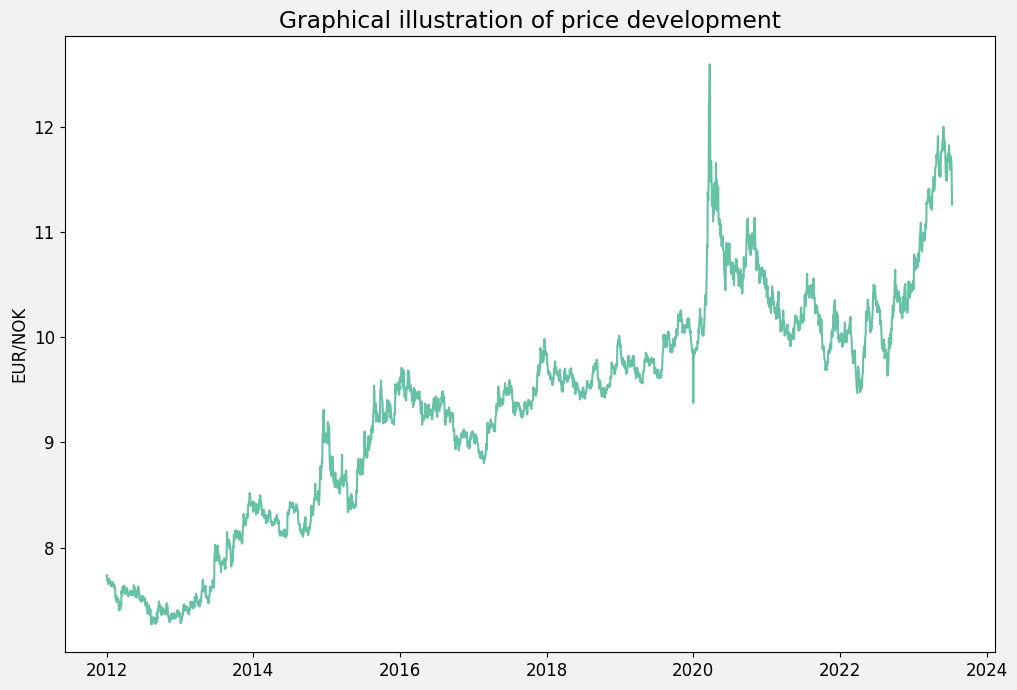

In [104]:
# Plotting the development of the currency rate
fig, ax= plt.subplots(1,1, figsize=(12,8))
ax.plot(df.index, df.Cur_rate)
ax.set_ylabel("EUR/NOK")
ax.set_title("Graphical illustration of price development")
plt.show()

As observed from the plot produced above, it is evident that the Norwegian Kroner has experienced a substantial decrease in its value compared to the Euro. This negative trend for the NOK began around the year 2023 and has reamined relatively consistent upwards since then. Additionaly, it is notable that the EUR/NOK exchange rate had a significant spike when the Covid-19 pandemic emerged in February 2020. However, there was a subsequent correction in its price, resulting in a dip during the previous year. In 2023 however, there has been a notable and dramatic increase in the upward trend for the EUR/Nok exchange rate.




# 3.3 Data Handling

We need to normalize our data with the "sklearn.preprocessing" module, and utilize the "MinMaxScaler" function. Scaling the data between 0 and 1 is accomplished using the code below:

In [105]:
# Normalize our data, since this is what the model expects
scaler = MinMaxScaler(feature_range=(0,1))

# Reshaping our data into a 2D array with a single column, this is required because the method "fit_transform" expects a 2D array as input
scaled_data = scaler.fit_transform(df["Cur_rate"].values.reshape(-1,1))

In [106]:
# Initiliaze empty lists for training data input and output, tomorrows price will be the target y
x = []
y = []

# We need to iterate through the sccaled data, starting from the prediction days index
for i in range(1, len(scaled_data)):
  # Append the previous prediction days values to x_train
  x.append(scaled_data[i-1: i, 0])

  # Append the current value to y_train
  y.append(scaled_data[i, 0])


# Convert the x and y lists to numpy arrays
x, y = np.array(x), np.array(y)

In [107]:
# We split into training and test, for both x and y
x_train, x_test, y_train, y_test= train_test_split(x, y , train_size=0.8, random_state=42, shuffle=False)

In [108]:
# Reshape x_train and x_test to a 3D array with the appropiate dimensions for the LSTM Model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# 3.4 Define and implement the LSTM Model



Based on multiple different articles on the internet about the number of neuros and layers of the LSTM model, I concluded to go with a random value for both of them. Further work could be to test and tweek these parameters.

In [109]:
# In the next section we define a function that creates and configure the LSTM model
def LSTM_model() -> Sequential:
  # Define number of neuros and the dropout rate
  num_neuros = 100
  drop_rate = 0.2

  # We initialize a sequential model
  model = Sequential()

  # Add the first LSTM layer with 100 units, input shape and return sequences
  model.add(LSTM(units=num_neuros, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
  # We add a dropout to avoid overfitting
  model.add(Dropout(drop_rate))

  # Add a second layer of LSTM
  model.add(LSTM(units=num_neuros, return_sequences=True))
  # Add another dropout to avoid overfitting
  model.add(Dropout(drop_rate))

  # Add a third layer with 100 units
  model.add(LSTM(units=num_neuros))
  # Add another dropout to avoid overfitting
  model.add(Dropout(drop_rate))

  # Add a dense output layer with one unit
  model.add(Dense(units=1))

  # Return the initialized and configurated model
  return model

In [110]:
# Defining the model
model_LSTM = LSTM_model()

# We configure the model when calling on compile
model_LSTM.compile(
    optimizer = "adam",
    loss = "mean_squared_error")

model_LSTM.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 1, 100)            40800     
                                                                 
 dropout_12 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_13 (LSTM)              (None, 1, 100)            80400     
                                                                 
 dropout_13 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_14 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_14 (Dropout)        (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                

# 3.5 Fit and train the model

In [111]:
# Fit the model for the training data and add the callback for our checkpointer
model_LSTM.fit(
    x_train, y_train,
    epochs = 50,
    batch_size = 32,
    validation_split=0.2
)

Epoch 1/50
61/61 [==============================] - 7s 24ms/step - loss: 0.0353 - val_loss: 0.0373
Epoch 2/50
61/61 [==============================] - 1s 8ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 3/50
61/61 [==============================] - 1s 8ms/step - loss: 8.3085e-04 - val_loss: 0.0014
Epoch 4/50
61/61 [==============================] - 0s 8ms/step - loss: 7.1862e-04 - val_loss: 0.0013
Epoch 5/50
61/61 [==============================] - 0s 8ms/step - loss: 6.7368e-04 - val_loss: 0.0012
Epoch 6/50
61/61 [==============================] - 0s 8ms/step - loss: 6.0929e-04 - val_loss: 6.0683e-04
Epoch 7/50
61/61 [==============================] - 0s 8ms/step - loss: 6.5526e-04 - val_loss: 3.3981e-04
Epoch 8/50
61/61 [==============================] - 1s 10ms/step - loss: 6.6499e-04 - val_loss: 3.4233e-04
Epoch 9/50
61/61 [==============================] - 1s 11ms/step - loss: 6.1795e-04 - val_loss: 3.3510e-04
Epoch 10/50
61/61 [==============================] - 1s 11ms/step - los

In [112]:
# We can now print out the R2-score for our test set
r2 = r2_score(y_test, model_LSTM.predict(x_test))
print(f"The r2 for our test set is: {(r2)*100:.2f}%")

19/19 [==============================] - 1s 5ms/step
The r2 for our test set is: 98.37%


As we can see by the R2 score above, our LSTM model has a impressive result.

# 3.6 Predicton the dataset

In [113]:
# Prediction on the whole dataset
predicted_values = model_LSTM(x)

# In order to use the ravel() function
np_config.enable_numpy_behavior()

#Make a list using the ravel() functiona and the tolist()
predicted_list = predicted_values.ravel().tolist()

#Resetting the Index so we can call on our Date-column below
df = index_reset(df)

#Make a dataframe
df_predicted = df[1:][["Date"]]
df_predicted["predictions"] = predicted_list
df_predicted["Close_Cur_rate"] = scaled_data[1:]
df_predicted

,Date,predictions,Close_Cur_rate
1,2012-01-03,0.092854,0.087891
2,2012-01-04,0.093166,0.083722
3,2012-01-05,0.089098,0.078182
4,2012-01-06,0.083697,0.078858
5,2012-01-09,0.084356,0.071721
...,...,...,...
3003,2023-07-10,0.814183,0.824359
3004,2023-07-11,0.804672,0.799472
3005,2023-07-12,0.782068,0.775009
3006,2023-07-13,0.759673,0.748970


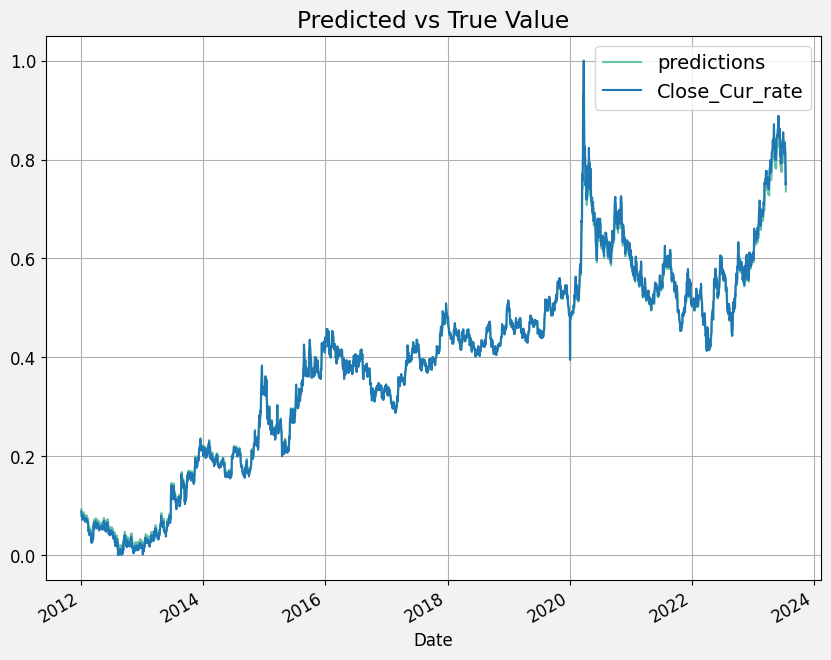

In [114]:
# Plot the data
df_predicted.plot(x="Date", y=df_predicted.columns[1:], title ="Predicted vs True Value")
plt.grid()
plt.show()

In [115]:
# We can transform our predicted values back to real price development
predicted_Cur_rate = rescaler(predicted_values)
actual_cur_rate = rescaler(x)

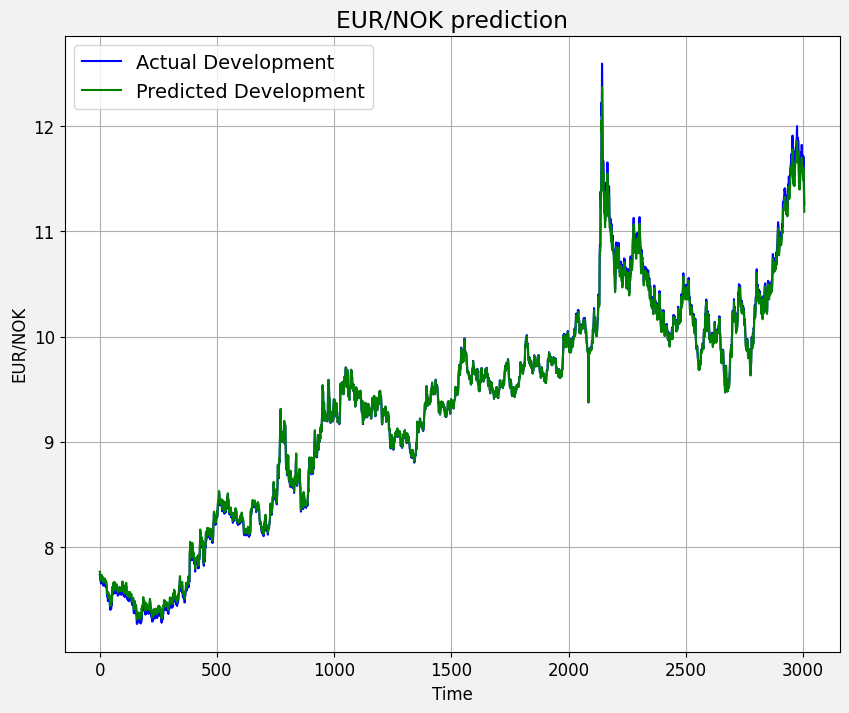

In [116]:
# Plotting the currency rate development
plot_pred(actual_cur_rate,predicted_Cur_rate)

# 4. Last comment

As we can see from both of our plots, the LSTM has produced good prediction results for the EUR/NOK currency exchange rate. The model identified the trend in the actual development and is almost identital to the true prices. This is beacuas the model was able to learn from the sequence of historical data and used that information to make more accurate predictions for the future "price" development.


Further practice could be to test and change the hyperparameter for the LSTM model, the number of neuros and layers.